# Exercise5——偏差和方差

练习绘制学习曲线，以观察不同的参数下学习曲线的变化情况。根据学习曲线判断是高偏差还是高方差，然后调整模型。

In [250]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt

In [251]:
def load_data(path):
    '''
        pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel the results
    '''
    d = sio.loadmat(path)
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [252]:
X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')

In [253]:
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

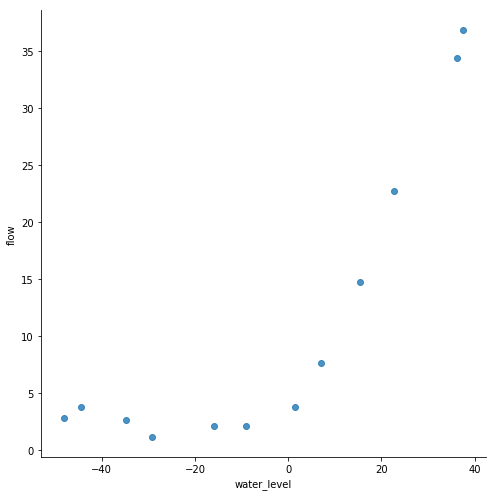

In [254]:
df = pd.DataFrame({'water_level':X, 'flow':y})
sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)
plt.show()

In [255]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

### 代价
<img style="float: left;" src="../img/linear_cost.png">

In [256]:
def cost(theta, X, y):
    '''
    X : (m, n), y : (m, ), theta : (n, )
    '''
    m = X.shape[0]
    inner = X @ theta - y    # (m, 1)
    square_sum = inner.T @ inner
    cost = square_sum / (2*m)
    
    return cost

In [257]:
theta = np.ones(X.shape[1])    # 初始化theta
cost(theta, X, y)          # 看看初始化theta目前的代价，我们的任务就是最小化这个cost

303.9515255535976

### 正则化代价

In [258]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = (l/(2*m)) * np.power(theta[1:], 2).sum()
    return cost(theta, X, y) + regularized_term

### 向量化梯度
<img style="float: left;" src="../img/vector_gradient.png">

In [259]:
def gradient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y)
    return inner / m

In [260]:
gradient(theta, X, y)    # 看一下目前初始化的theta所在的点的两个特征方向的斜率

array([-15.30301567, 598.16741084])

### 梯度正则化
<img style="float: left;" src="../img/linear_reg_gradient.png">

In [261]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = theta.copy()
    regularized_term[0] = 0
    return gradient(theta, X, y) + (l/m)*regularized_term

In [262]:
regularized_gradient(theta, X, y)    # 看一看

array([-15.30301567, 598.25074417])

## 拟合数据

In [263]:
def linear_regression_np(X, y, l=1):
    # init theta
    theta = np.ones(X.shape[1])
    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       method='TNC',
                       args=(X, y, l),
                       jac=regularized_gradient,
                       options={'disp':True})
    return res

In [264]:
theta = np.ones(X.shape[1])
finall_theta = linear_regression_np(X, y, l=0).get('x')

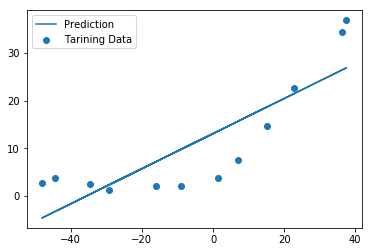

In [265]:
k = finall_theta[1]
b = finall_theta[0]
plt.scatter(X[:,1], y, label='Tarining Data')
plt.plot(X[:,1], k*X[:,1]+b, label='Prediction')    # y = kx +b
plt.legend(loc=2)
plt.show()

In [266]:
tarning_cost, cv_cost = [], []

1. 使用训练集拟合模型
2. 计算训练集代价和验证集代价，未使用正则化，即 $\lambda=0$

In [267]:
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression_np(X[:i, :], y[:i], l=0)    # 逐渐增加样本数
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    
    tarning_cost.append(tc)
    cv_cost.append(cv)

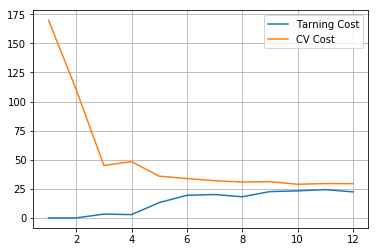

In [268]:
plt.plot(np.arange(1, m+1), tarning_cost, label='Tarning Cost')
plt.plot(np.arange(1, m+1), cv_cost, label='CV Cost')
plt.legend(loc=0)
plt.grid()
plt.show()

可以看出代价比较大，欠拟合，模型不太好。

## 使用多项式回归试试

##### 定义多项式

In [269]:
def poly_feature(X, power, as_ndarray=False):
    data = {'f{}'.format(i):np.power(X, i) for i in range(1, power+1)}
    df = pd.DataFrame(data)
    return df.values if as_ndarray else df        # matrix 即 ndarray

##### 归一化数据

In [270]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

##### 最终的多项式函数

In [271]:
def prepare_poly_data(*args, power):
    ''' *args : keep feeding in X, Xval, Xtest will return in the same order '''
    def prepare(x, power=power):
        # expand feature
        df = poly_feature(x, power)
        # normalization
        data = normalize_feature(df).values
        # add intercept term
        return np.insert(data, 0, np.ones(data.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

In [272]:
X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')

## 开始准备数据
1. 扩展数据到8阶，或者拓展成你想要的多项式幂次
2. don't forget intercept term

In [273]:
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)

## 画出学习曲线

##### 打包学习曲线函数

In [274]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    m = X.shape[0]
    training_cost, cv_cost = [], []
    
    for i in range(1, m+1):
        res = linear_regression_np(X[:i, :], y[:i], l=l)
        
        # remember, you are computing the non-regularized cost. Regularization is used to fit parameters only!
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)
        
        training_cost.append(tc)
        cv_cost.append(cv)
        
    plt.plot(np.arange(1, m+1), training_cost, label='Training Cost')
    plt.plot(np.arange(1, m+1), cv_cost, label='CV Cost')
    plt.legend(loc=1)
    plt.show()

##### 先看看没有正则化的8阶多项式效果

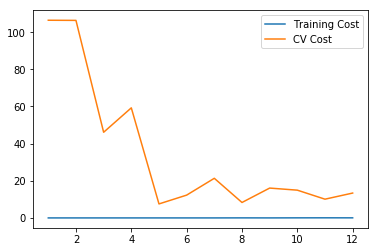

In [275]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)

可以看到，训练集上的代价为0，说明过拟合了。

##### 我们再看看，惩罚系数为1时的效果。

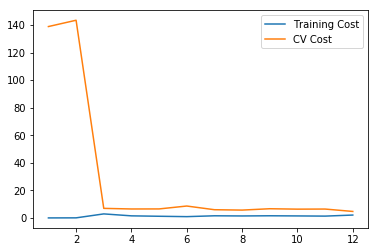

In [276]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)

过拟合状态有所缓和

##### 再看看惩罚系数为100时的效果

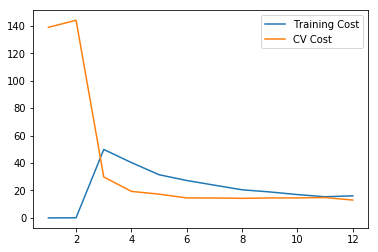

In [277]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=10)

惩罚系数太大，缓解过拟合过度了，变成欠拟合了。

## 经过上面几次随机的测试，发现对于8阶多项式，最佳的 $\lambda$ 应该在0-10之间
### 所以我们画出0-10之间的各个 $\lambda$ 对应的cost，以便我们找到最佳的那个 $\lambda$

In [278]:
l_condidate = np.linspace(0, 10, 41)
l_condidate

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [279]:
training_cost, cv_cost, test_cost = [], [], []
for l in l_condidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    ts = cost(res.x, Xtest_poly, ytest)
    
    training_cost.append(tc)
    cv_cost.append(cv)
    test_cost.append(ts)

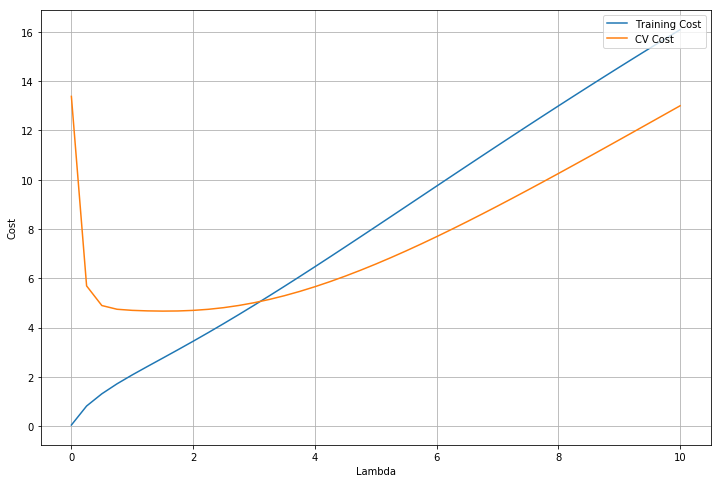

In [280]:
plt.figure(figsize=(12, 8))
plt.plot(l_condidate, training_cost, label='Training Cost')
plt.plot(l_condidate, cv_cost, label='CV Cost')
plt.legend(loc=1)
plt.xlabel('Lambda')
plt.ylabel('Cost')
plt.grid()
plt.show()

可以看到验证集最好的代价是 $\lambda$ 在0-2之间

#### 我们将所有的 $\lambda$ 在验证集和测试集的代价都打印出来

In [288]:
for i,j,h in zip(l_condidate, cv_cost, test_cost):
    print('CV Cost(l={:.2f}) = {}, Test Cost(l={:.2f}) = {}'.format(i, j, i, h))

CV Cost(l=0.00) = 13.38368335936944, Test Cost(l=0.00) = 10.122298845834932
CV Cost(l=0.25) = 5.689263830050454, Test Cost(l=0.25) = 7.507927722821644
CV Cost(l=0.50) = 4.892794467888311, Test Cost(l=0.50) = 7.066579494855458
CV Cost(l=0.75) = 4.741147014375082, Test Cost(l=0.75) = 7.16567377083151
CV Cost(l=1.00) = 4.696663548477304, Test Cost(l=1.00) = 7.466265914249742
CV Cost(l=1.25) = 4.675460251539405, Test Cost(l=1.25) = 7.867473076191957
CV Cost(l=1.50) = 4.666397480323288, Test Cost(l=1.50) = 8.328509612342799
CV Cost(l=1.75) = 4.671873348295794, Test Cost(l=1.75) = 8.829414305619778
CV Cost(l=2.00) = 4.695268162787502, Test Cost(l=2.00) = 9.358710661644263
CV Cost(l=2.25) = 4.739430100408731, Test Cost(l=2.25) = 9.909372661821077
CV Cost(l=2.50) = 4.805739296050716, Test Cost(l=2.50) = 10.47608596865792
CV Cost(l=2.75) = 4.894620261844558, Test Cost(l=2.75) = 11.055183038881838
CV Cost(l=3.00) = 5.005830664198133, Test Cost(l=3.00) = 11.643931713037912
CV Cost(l=3.25) = 5.138

通过上述的数据可以看出，$\lambda=0.5$ 左右时，能得到最优的代价

## 以上为8阶多项式调节不同的正则化惩罚系数的过程及效果，也可以再试着改变多项式的阶数